<a href="https://colab.research.google.com/github/daltonismo15/Retina-MNIST-entropia-di-Shannon/blob/main/Retina_MNIST_entropia_di_Shannon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Piccola CNN per la classificazione di handwritten digits (dataset MNIST), lo scheletro è preso da un tutorial di pytorch (https://www.youtube.com/playlist?list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4), ho fatto alcune modifiche per aggiungere del rumore (blocchi neri), per far funzionare la rete solo per il riconoscimento di 9 cifre (numeri da 0 a 9) e nel ciclo di evaluation per avere la possibilità di valutare l'entropia di ogni cifra.

In [ ]:
class BlackBlock(object):
    def __init__(self, block_size=5, num_blocks=1):
        self.block_size = block_size
        self.num_blocks = num_blocks

    def __call__(self, tensor):
        c, h, w = tensor.size()
        for _ in range(self.num_blocks):
            top_left_x = random.randint(0, w - self.block_size)
            top_left_y = random.randint(0, h - self.block_size)
            tensor[:, top_left_y:top_left_y + self.block_size, top_left_x:top_left_x + self.block_size] = 0
        return tensor

    def __repr__(self):
        return f"{self.__class__.__name__}(block_size={self.block_size}, num_blocks={self.num_blocks})"

Definizione dei parametri e caricamento del dataset MNIST

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #cosi se c'hai la GPU runna lì


input_size = 784 # 28x28
hidden_size = 500
num_classes = 10 # digits from 0 to 9
num_epochs = 10
batch_size = 100 #dammene 100
learning_rate = 0.001
annerito = 7


test_transform = transforms.Compose([
    transforms.ToTensor(),
    BlackBlock(block_size=annerito, num_blocks=2),
])


train_dataset = torchvision.datasets.MNIST(root='./data',  #la cartella dove metti i dati
                                           train=True,  #ci dobbiamo fare il train
                                           transform=transforms.ToTensor(),  #traformalo in un tensore
                                           download=True) #download se non ce l'hai

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=4, #@uyfliycfliycf;if
                                          shuffle=False) #non importa for the evaluescion


La rete è molto base: trasformazione lineare, ReLu che $\mathbb{R}\ → [0,1]$ e poi un'altra trasformazione lineare

In [ ]:
#One hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes): #num_classes = output_size
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) #il primo layer si prende in imput l'imput size ed esce con un numero di cose = hidden_size
        self.relu = nn.ReLU() # ReLu
        self.l2 = nn.Linear(hidden_size, num_classes)  # ed usciamo con 9 cose

    def forward(self, x): #passo in avanti
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end perchè poi usamo SSL che gia ce l'ha
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Fase di allenamento
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  #enumerate ci da l'index
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784] #100 vettori colonna lunghi 784
        images = images.reshape(-1, 28*28).to(device) #-1 lo fa da solo
        labels = labels.to(device)

        # Passo in avanti
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Gradient descend
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')



Epoch [1/10], Step [100/600], Loss: 0.3531
Epoch [1/10], Step [200/600], Loss: 0.2440
Epoch [1/10], Step [300/600], Loss: 0.2053
Epoch [1/10], Step [400/600], Loss: 0.1218
Epoch [1/10], Step [500/600], Loss: 0.1353
Epoch [1/10], Step [600/600], Loss: 0.2693
Epoch [2/10], Step [100/600], Loss: 0.1739
Epoch [2/10], Step [200/600], Loss: 0.2514
Epoch [2/10], Step [300/600], Loss: 0.1979
Epoch [2/10], Step [400/600], Loss: 0.1898
Epoch [2/10], Step [500/600], Loss: 0.1219
Epoch [2/10], Step [600/600], Loss: 0.0764
Epoch [3/10], Step [100/600], Loss: 0.1053
Epoch [3/10], Step [200/600], Loss: 0.0696
Epoch [3/10], Step [300/600], Loss: 0.0936
Epoch [3/10], Step [400/600], Loss: 0.1675
Epoch [3/10], Step [500/600], Loss: 0.0797
Epoch [3/10], Step [600/600], Loss: 0.0256
Epoch [4/10], Step [100/600], Loss: 0.0543
Epoch [4/10], Step [200/600], Loss: 0.0169
Epoch [4/10], Step [300/600], Loss: 0.0991
Epoch [4/10], Step [400/600], Loss: 0.0467
Epoch [4/10], Step [500/600], Loss: 0.1078
Epoch [4/10

Prendo le 10 cifre da 0 a 9 e le stampo per farmi un'idea del segnale che sto trasmettendo (leggendo).

L'aggiunta dei blocchi neri a coprire dei pixel delle immagini serve a simulare il rumore che subisce un segnale.

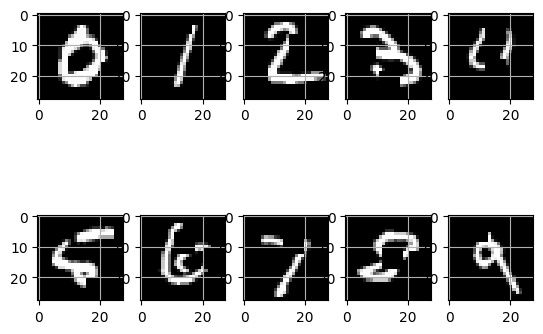

In [ ]:
indices = []
for i in range(10):
    for index in range(len(test_dataset)):
        if test_dataset[index][1] == i:
            indices.append(index)
            break

from torch.utils.data import Subset

test_subset = Subset(test_dataset, indices)




test_loader = torch.utils.data.DataLoader(dataset=test_subset,
                                          batch_size=10,
                                          shuffle=False) #non importa for the evaluescion





examples = iter(test_loader)
example_data, example_targets = next(examples)

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.grid()
plt.show()

In [ ]:
import numpy as np

Definizione dell'entropia di Shannon

In [ ]:
def shannon_entropy(probabilities):
    probabilities = np.array(probabilities)
    probabilities = probabilities[probabilities > 0]  # no log(0) nel caso
    return -np.sum(probabilities * np.log2(probabilities))

Cicilo di valutazione delle prestazioni della rete (essendo il nostro test_set molto piccolo non posso fare stime reali sul funzionamento della rete ma non è quello che mi interessa, purtroppo questo tipo di algoritmo non è un'idea mia e siamo abbastanza certi che funzioni a dovere).

Mi faccio dare la distribuizione di probabilità {P} associata ad ogni canale (quindi ad ogni cifra) applicando la funzione SoftMax all'output della rete.

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    count = 0
    entropy = []
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        prob = nn.Softmax(dim=1)(outputs)
        #print(prob)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        print(f'Predicted: {predicted.numpy()} \nLabels:    {labels.numpy()}')
        for p in prob:
          entropya = shannon_entropy(p.numpy())
          entropy.append(entropya)
        print(f'entropia di ogni canale (digit): {entropy}')
    print(f'Accuracy of the network on the 10 test images: {n_correct} su {n_samples}')


Predicted: [0 1 2 8 4 5 6 7 5 4] 
Labels:    [0 1 2 3 4 5 6 7 8 9]
entropia di ogni canale (digit): [0.103033595, 0.01410418, 0.014693713, 0.5910282, 0.0067259753, 0.030808695, 0.00024006296, 0.00077312137, 0.42923236, 0.2373108]
Accuracy of the network on the 10 test images: 7 su 10


Noto come più l'entropia è alta maggiore è la probabilità di errore nel riconoscimento della cifra (la trasmissione del segnale quindi viene totalmente compromessa), questo le varie probablità associate ad ogni label sono simili fra loro.